In [2]:
# import ocean row module
from mod_ocean_row import ocean_row

In [4]:
# reload package
import importlib
import mod_ocean_row
importlib.reload(mod_ocean_row)
from mod_ocean_row import ocean_row

# 1.1 Model configurations

In [5]:
# create dictionary of starting location
# Dsloc = {'start_name':'Fremantle'    ,'start_lat':-32.056946,'start_lon':115.743889}
# Dsloc = {'start_name':'Geraldton'    ,'start_lat':-28.782387,'start_lon':114.607513} 
Dsloc = {'start_name':'Kalbarri'     ,'start_lat':-27.711053,'start_lon':114.164536} 
# Dsloc = {'start_name':'Carnarvon'    ,'start_lat':-24.883717,'start_lon':113.656956} 
# Dsloc = {'start_name':'Exmouth'      ,'start_lat':-21.930724,'start_lon':114.122389} 
# Dsloc = {'start_name':'Broome'       ,'start_lat':-17.951221,'start_lon':122.244327} 

# create dictionary of destination location
Deloc = {'stop_name':'Dar es Salaam' ,'stop_lat':-6.766305  ,'stop_lon':39.195973  } # create dictionary of destination location

# date and time
tod_0     = '2018-05-01 03:00:00' # starting datetime
tod_start = ['06:00:00','14:00:00'] # start rowing [time of day]
tod_stop  = ['12:00:00','20:00:00'] # stop rowing [time of day]
Dtime     = {'tod_0':tod_0,'tod_start':tod_start,'tod_stop':tod_stop} # create dictionary

# rowing properties
m     = 670 # wiegth [kg]

# convert m/s to kts
tokts = 1.94384449 # convert m/s to kts

# rowing speed perfect conditions
vperf = 1.7/tokts # boat velocity in perfect conditions [m/s]

# water friction - boat
rhow  = 1024 # density water [kg/m^3]
Aw    = 15 # frontal area exposed to water
Cdw   = 0.005 # friction coef. water 
Gw    = rhow*Cdw*Aw/2 # water friction constant

# water friction - anchor
GwA   = 50*Gw # water friction constant sea anchor

# friction ratio boat
G     = .01 # ratio of air friction cosntant to water friction constant (Ga/Gw)

# air friction 
Ga    = G*Gw # air friction constant

Drow_prop = {'m':m,'vperf':vperf,'Gw':Gw,'GwA':GwA,'Ga':Ga} # create dictionary of all rowing properties

# combine all configurations
mcf = Dsloc | Deloc | Drow_prop | Dtime # model configuration (as dictionary)
mcf # print all configuration options

{'start_name': 'Kalbarri',
 'start_lat': -27.711053,
 'start_lon': 114.164536,
 'stop_name': 'Dar es Salaam',
 'stop_lat': -6.766305,
 'stop_lon': 39.195973,
 'm': 670,
 'vperf': 0.8745555566536086,
 'Gw': 38.4,
 'GwA': 1920.0,
 'Ga': 0.384,
 'tod_0': '2018-05-01 03:00:00',
 'tod_start': ['06:00:00', '14:00:00'],
 'tod_stop': ['12:00:00', '20:00:00']}

# 1.2 Hindcast data

In [6]:
import xarray as xr
import os
import numpy as np

hc_quality = 'high' # set hindcast quality to low or high
# when hc_quality = low
#     air   2007-05-01 ... 2020-12-01
#     water 1993-01-16 ... 2020-05-16
#     waves 2002-01-15 ... 2020-12-31

# when hc_quality = high
#     air   2009-04 ... 2009-08 & 2010-07 ... 2010-11 
#     water 2009 ... 2010


if hc_quality == 'low':
    # air velocity (wind)
    dsa0 = xr.open_dataset( r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\CERSAT-GLO-REP_WIND_L4-OBS_FULL_TIME_SERIE_1648775425193.nc').load()
    dsa  = xr.Dataset(
        data_vars=dict(
            # correct wind dataset (wrong direction of winds)
            ua  = (["time", "lat", "lon"], dsa0.eastward_wind.isel(depth=0).values),
            va  = (["time", "lat", "lon"], dsa0.northward_wind.isel(depth=0).values)),
        coords=dict(
            lon  = dsa0.longitude.values,
            lat  = dsa0.latitude.values,
            time = dsa0.time.values))

    # water velocity (currents)
    dsw0 = xr.open_dataset( r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\nemo_monthly_mean.nc').load()
    dsw  = xr.Dataset(
        data_vars=dict(
            uw  = (["time", "lat", "lon"], dsw0.uo.isel(depth=0).values),
            vw  = (["time", "lat", "lon"], dsw0.vo.isel(depth=0).values),
            Tw  = (["time", "lat", "lon"], dsw0.thetao.isel(depth=0).values)),
        coords=dict(
            lon  = dsw0.longitude.values,
            lat  = dsw0.latitude.values,
            time = dsw0.time.values))

    # wave heights 
    dswh0 = xr.open_dataset(r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data/cmems_obs-wave_glo_phy-swh_my_multi-l4-2deg_P1D_1648776708969.nc').load()
    dswh  = xr.Dataset(
        data_vars=dict(
            # correct wind dataset (wrong direction of winds)
            H_day_mean = (["time", "lat", "lon"], dswh0.VAVH_DAILY_MEAN.values),
            H_day_max  = (["time", "lat", "lon"], dswh0.VAVH_DAILY_MAX.values)),
        coords=dict(
            lon  = dswh0.longitude.values,
            lat  = dswh0.latitude.values,
            time = dswh0.time.values))

    hc = {'dsa':dsa,'dsw':dsw,'dswh':dswh} # create single dictonary of all datasets
    del dsa0,dsa,dsw0,dsw,dswh0,dswh

elif hc_quality == 'high':
    path_data = r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\high_quality_hindcast'
    arr = np.array(os.listdir(path_data))

    # air velocity (wind)
    ia   = np.array([i[0:10]=='ERA5_WINDS' for i in arr])
    dsa0 = xr.open_mfdataset(np.array([path_data+'\\'+i for i in arr[ia]]))
    dsa  = xr.Dataset(
        data_vars=dict(
            # correct wind dataset (wrong direction of winds)
            ua  = (["time", "lat", "lon"], np.flip(dsa0.u10.values,axis=1)),
            va  = (["time", "lat", "lon"], np.flip(dsa0.v10.values,axis=1))),
        coords=dict(
            lon  = dsa0.longitude.values,
            lat  = np.flip(dsa0.latitude.values),
            time = dsa0.time.values))

    # water velocity (currents)
    iw   = np.array([i[0:5]=='Glory' for i in arr])
    dsw0 = xr.open_mfdataset(np.array([path_data+'\\'+i for i in arr[iw]]))
    dsw  = xr.Dataset(
        data_vars=dict(
            uw  = (["time", "lat", "lon"], dsw0.uo.isel(depth=0).values),
            vw  = (["time", "lat", "lon"], dsw0.vo.isel(depth=0).values)),
        coords=dict(
            lon  = dsw0.longitude.values,
            lat  = dsw0.latitude.values,
            time = dsw0.time.values))

    hc = {'dsa':dsa,'dsw':dsw} # create single dictonary of all datasets
    del dsa0,dsa,dsw0,dsw

hc

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\23513098\\OneDrive - The University of Western Australia\\Documents\\Rick\\Work\\RIOP\\Scripts\\Data\\high_quality_hindcast'

# 1.3 Previous ocean rows

In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
import re
from   geographiclib.geodesic      import Geodesic

# Load data of ocean row Sarah Outen
kml_file = r"C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\Track_Sarah_Outen.kml" # file directory

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' # configure kml reader 
df = gpd.read_file(kml_file, driver='KML') # read kml file
x  = df.geometry.x.values # set longitude values
y  = df.geometry.y.values # set latitude values
t  = pd.Series([datetime.strptime(re.search(r'\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}', x).group(), '%d/%m/%Y %H:%M:%S') for x in df.Description]) # create time series

dfS = pd.DataFrame({'datet':t,'lon':x,'lat':y}) # store in dataframe
dfS = dfS.sort_values(by=['datet']).reset_index(drop=True) # sort by time

# Load data of ocean row Erden Eruc
tab     = pd.read_csv(r'C:\Users\23513098\OneDrive - The University of Western Australia\Documents\Rick\Work\RIOP\Scripts\Data\Track_Erden_Eruc.csv',encoding= 'unicode_escape') # file directory
tstring = [x[x.find('-')+2:x.find('(')-1]+' '+x[x.find('(')+1:x.find(')')-4] for x in tab['Day/Date']] # get time as string
tstring = [x.replace('\xa0',' ') for x in tstring] # clean up time strings
t       = pd.to_datetime(tstring) # convert to datetime

# convert latitude 
deg       = np.array([re.split('[::]', x)[0] for x in tab.Latitude.values.astype(str)]).astype(int)
minutes   = np.array([re.split('[::]', x)[1] for x in tab.Latitude.values.astype(str)]).astype(int)
seconds   = np.array([re.split('[::]', x)[2][:-1] for x in tab.Latitude.values.astype(str)]).astype(int)
direction = np.array([re.split('[::]', x)[2][-1] for x in tab.Latitude.values.astype(str)]).astype(str)
y         = (deg + minutes/60 + seconds/(60*60)) * np.array([(-1 if x in ['W', 'S'] else 1) for x in direction])

# convert longitude 
deg       = np.array([re.split('[::]', x)[0] for x in tab.Longitude.values.astype(str)]).astype(int)
minutes   = np.array([re.split('[::]', x)[1] for x in tab.Longitude.values.astype(str)]).astype(int)
seconds   = np.array([re.split('[::]', x)[2][:-1] for x in tab.Longitude.values.astype(str)]).astype(int)
direction = np.array([re.split('[::]', x)[2][-1] for x in tab.Longitude.values.astype(str)]).astype(str)
x         = (deg + minutes/60 + seconds/(60*60)) * np.array([(-1 if x in ['W', 'S'] else 1) for x in direction])

dfE = pd.DataFrame({'datet':t,'lon':x,'lat':y}) # store in dataframe
dfE = dfE.sort_values(by=['datet']).reset_index(drop=True) # sort by time

# calculate average boat speed
for df in [dfS,dfE]:
    N  = len(df) # number of data points
    ub = np.empty(N) # allocate boat speed longitudinal ub
    vb = np.empty(N) # allocate boat speed lateral vb
    for i in range(N-1): 
        geo_data = Geodesic.WGS84.Inverse(df.lat[i],df.lon[i],df.lat[i+1],df.lon[i+1]) # get geo data between points
        ds = geo_data['s12'] # distance between points
        dy = ds*np.cos(geo_data['azi1']/180*np.pi) # lateral distance per step (in m)
        dx = ds*np.sin(geo_data['azi1']/180*np.pi) # longitudinal distance per step (in m)
        dt = (df.datet[i+1]-df.datet[i])/np.timedelta64(1, 's') # time step (in s)
        ub[i] = dx/dt # boat speed longitudinal
        vb[i] = dy/dt # boat speed lateral
    ub[N-1] = np.nan # no boat speed for last point
    vb[N-1] = np.nan 
    df['ub'] = ub # include in dataframe
    df['vb'] = vb

# include water (current) and air (wind) speeds to dataframes of previous rows
# datasets
dsa_uv = np.stack([hc['dsa'].ua.values,hc['dsa'].va.values]) # hindcast air speeds
dsw_uv = np.stack([hc['dsw'].uw.values,hc['dsw'].vw.values]) # hindcast water speeds

# dataset coordinates
dsa_time = hc['dsa'].time.values
dsa_lon  = hc['dsa'].lon.values
dsa_lat  = hc['dsa'].lat.values
dsw_time = hc['dsw'].time.values
dsw_lon  = hc['dsw'].lon.values
dsw_lat  = hc['dsw'].lat.values

for df in [dfS,dfE]: # loop over dataframes
    N = len(df) # number of data poitns
    
    # allocate speeds
    ua = np.empty(N) # longitudinal air
    va = np.empty(N) # lateral air
    uw = np.empty(N) # longitudinal water
    vw = np.empty(N) # lateral water

    for i in range(N):
        datet = np.array(df.datet[i]).astype('datetime64[s]')
        lon = df.lon[i]
        lat = df.lat[i]
        X = np.array([[lon,lat]])
      
        Va,Vw = ocean_row.get_hindcast_at_loc(X,datet,dsa_uv,dsw_uv,dsa_time,dsa_lon,dsa_lat,dsw_time,dsw_lon,dsw_lat)
        uw[i] = Vw[0,0]
        vw[i] = Vw[0,1]
        ua[i] = Va[0,0]
        va[i] = Va[0,1]
        
    # add to dataframe
    df['uw'] = uw
    df['vw'] = vw
    df['ua'] = ua
    df['va'] = va

AttributeError: 'NoneType' object has no attribute 'drvsupport'

In [6]:
dfS

,datet,lon,lat,ub,vb,uw,vw,ua,va
0,2009-04-01 00:10:45,115.741112,-32.060280,-0.466145,0.687981,NaN,NaN,-2.880794,4.555759
1,2009-04-02 00:11:11,115.316948,-31.523335,-0.763080,0.515845,-0.174906,0.202066,-5.068670,3.793264
2,2009-04-03 03:10:41,114.540001,-31.068890,-0.611600,-0.094643,0.019212,-0.618320,-8.280478,4.153535
3,2009-04-04 00:10:27,114.055283,-31.132502,-0.467788,0.287482,-0.047853,-0.014484,-7.930624,1.236616
4,2009-04-05 00:10:26,113.632500,-30.907778,-0.448703,0.084727,0.329217,0.205886,-9.516319,1.305319
...,...,...,...,...,...,...,...,...,...
121,2009-07-31 00:12:46,60.877500,-21.186944,-0.949959,0.077099,-0.216657,-0.005799,-7.352673,-0.511639
122,2009-08-01 00:05:01,60.091667,-21.125278,-0.876382,0.378224,-0.146014,-0.077470,-4.675471,3.172679
123,2009-08-02 00:43:41,59.344722,-20.820556,-1.253545,0.179288,-0.177626,-0.145544,-5.504997,8.790437
124,2009-08-03 00:43:37,58.305278,-20.677500,0.000000,0.000000,-0.199897,0.011657,-8.852529,6.719393


In [7]:
dfE

,datet,lon,lat,ub,vb,uw,vw,ua,va
0,2010-07-13 03:50:00,113.651944,-24.896944,-0.831628,0.492963,NaN,NaN,-4.896448,2.238143
1,2010-07-14 04:00:00,112.938056,-24.508056,-0.729513,-0.009121,0.000288,-0.060115,-7.170469,3.222236
2,2010-07-15 04:00:00,112.316111,-24.513889,-0.454500,-1.035572,-0.322319,-0.778496,-5.206306,-1.476714
3,2010-07-16 04:00:00,111.926111,-25.321111,-0.567326,0.591598,-0.116568,-0.535232,-3.377381,3.997396
4,2010-07-17 04:00:00,111.441111,-24.858889,-0.474382,0.546657,-0.217965,-0.133802,-4.230973,8.825023
...,...,...,...,...,...,...,...,...,...
132,2010-11-22 04:00:00,46.595000,-14.490000,-0.056057,-0.453202,-0.072734,-0.149898,-2.684460,3.392698
133,2010-11-23 04:00:00,46.550000,-14.843889,-0.321145,-0.270546,-0.246665,-0.180537,-5.310462,3.294423
134,2010-11-24 04:00:00,46.291944,-15.055000,0.026233,-0.405906,-0.269876,-0.160543,-5.216439,1.093772
135,2010-11-25 04:00:00,46.313056,-15.371944,-0.031038,-0.236933,-0.162828,-0.085714,-1.901319,0.870329


# 2.1 overview
Create the following plots:

* Allowed rowing domain and shortest distance between starting point and destination
* Rowing interval as a function of time 
* Plot rowing speed as a function of the parallel wind speed (no waves and currents)
* Monthly average of hindcast data

/home/mnef/.local/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/mnef/.local/lib/python3.10/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


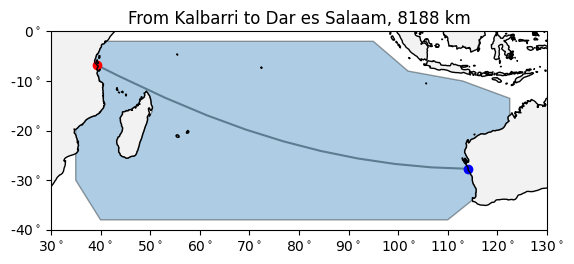

In [8]:
# plot shortest distance between starting point and destination. In addition, plot the allowed rowing domain
fig,ax = ocean_row(mcf).plt_overview()

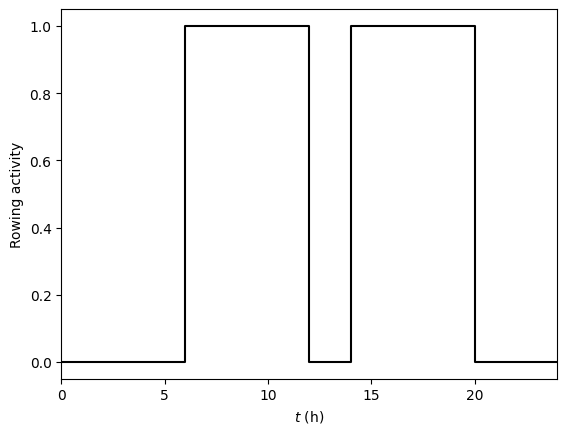

In [9]:
# plot rowing interval as a function of time (0 = resting, 1 = rowing)
fig,ax = ocean_row(mcf).plt_rowing_activity()

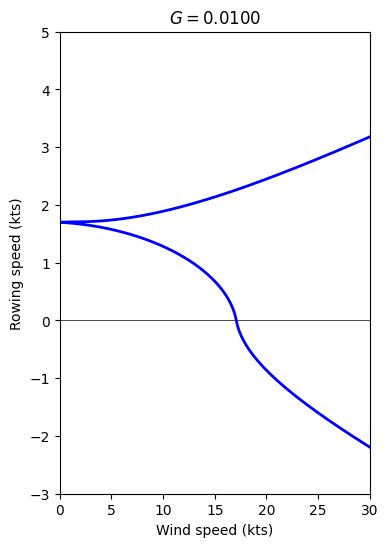

In [10]:
# plot rowing speed as a function of the parallel wind speed (no waves and currents)
fig,ax = ocean_row(mcf).plt_vrow_wind_only()

In [11]:
# monthly average of hindcast data
ptype = 'month_mean_annual'
# month_mean_all: mean per month of all available data
# month_mean_annual: mean per month per year

# ocean_row.plt_hindcast(hc,'air velocity',ptype=ptype) # air velocity
ocean_row.plt_hindcast(hc,'water velocity',ptype=ptype) # water velocity 
# ocean_row.plt_hindcast(hc,'water temperature',ptype=ptype) # water temperature
# ocean_row.plt_hindcast(hc,'daily wave height mean',ptype=ptype) # wave height mean
# ocean_row.plt_hindcast(hc,'daily wave height max',ptype=ptype) # wave height max 

NameError: name 'hc' is not defined

In [12]:
imax  = 700 # maximum number of iterations
rtmin = 200000 # minimum distance till target

# # case 1: row in direction of destination
# dmode = {'mode':'destination','anchor_drop':False,'filters_on':False}

# # case 2: optimization
# dmode = {'mode':'optimize','angle_max':90,'angle_Nstep':5,'Np':50}

# case 3: follow GPS
df        = dfE.copy() # load in dataframe
Xa_pr     = np.stack([df.lon,df.lat]).T # track locations
tod_0_pr  = str(df.datet[0]) # string of datetime to start row (optional)
datets_pr = df.datet.to_numpy()
dmode     = {'mode':'track','Xa_pr':Xa_pr,'tod_0':tod_0_pr,'anchor_drop':False,'filters_on':False}


%matplotlib notebook
Xs,Vas,Vws,Vs,datets,Nhists,Ns = ocean_row(mcf).run_ocean_row(hc,dmode,imax,rtmin)
%matplotlib inline

NameError: name 'dfE' is not defined

NameError: name 'Nhists' is not defined

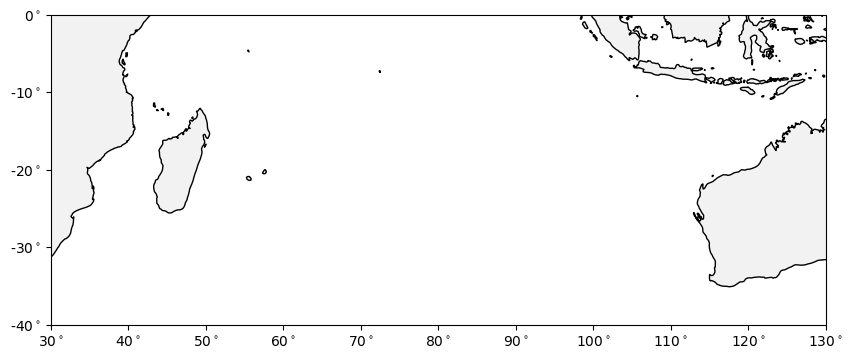

In [13]:
import matplotlib.pyplot as plt

ocean_row(mcf).plt_base_simple([30,130],[-40,0],10,10)
plt.gcf().set_size_inches(10,10)

N = Nhists.shape[0]

if dmode['mode']=='optimize':
    plt.scatter(Xs.reshape([-1,2])[:,0],Xs.reshape([-1,2])[:,1],0.1,color='b') # plot all possible routes
        
if dmode['mode']=='track':
    plt.plot(Xa_pr[:,0],Xa_pr[:,1],'k-',linewidth=1) # plot followed GPS track
    
Xf = ocean_row(mcf).get_fastest_route(Nhists,Xs) # get fastest route
plt.plot(Xf[:,0],Xf[:,1],'r-',linewidth=2) # plot fastest route
plt.show()

In [14]:
# plot polor plot
# set plot limits
xlims = [-20,20]
ylims = [-25,30]
zlims = [0,2.5]

# model rpw
# sample model row to daily
_,iday  = np.unique(datets.astype('datetime64[D]'),return_index=True) # get index of first timestamp of day

if dmode['mode'] == 'optimize':
    Xf  = ocean_row(mcf).get_fastest_route(Nhists,Xs) # get fastest route
    Xac = Xf[iday,:]
else:
    Xac = Xs[iday,0,:] # get locations
datetsc = datets[iday] # get timestamps

ocean_row.coords_to_polar(Xac,datetsc,hc,xlims=xlims,ylims=ylims,zlims=zlims) # model row

if dmode['mode']=='track': # compare to polar plot of track
    ocean_row.coords_to_polar(Xa_pr,datets_pr,hc,xlims=xlims,ylims=ylims,zlims=zlims) # previous row

NameError: name 'datets' is not defined